In [1]:
from mimic.utilities import *

from mimic.model_infer.infer_gLV_bayes import *
from mimic.model_infer import *
from mimic.model_simulate import *
from mimic.model_simulate.sim_gLV import *


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as at
import pickle
import cloudpickle


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Repeat Rutter & Dekker et al 2024 analysis

In [2]:
# Import the data
PM3_EntA_data = get_data('PM3-EntA-coculture.csv')

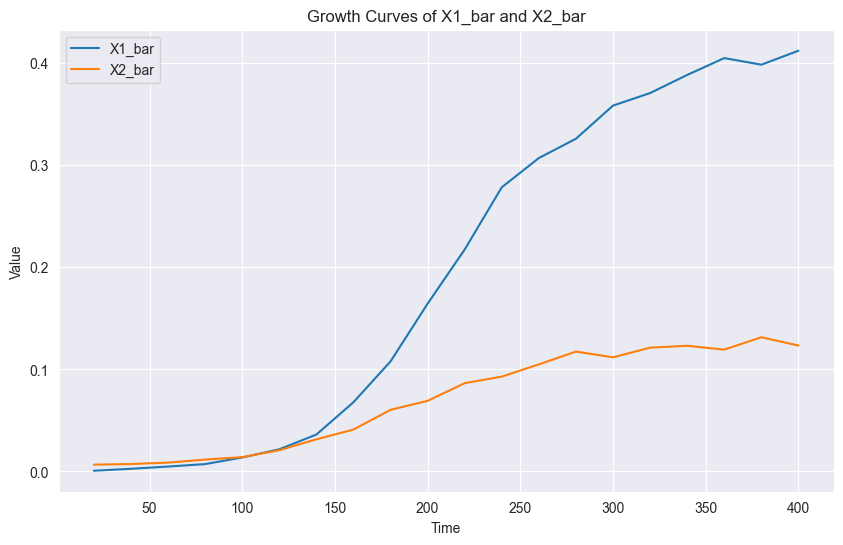

In [3]:
# Visualise the mean of the growth curves of both species grown in co-culture together
plot_growth_curves(PM3_EntA_data)

In [4]:
# Extract data and convert to numpyarrays

yobsdf = PM3_EntA_data.iloc[:, [1,2]]
yobs = yobsdf.to_numpy()
timesa = PM3_EntA_data.iloc[:, 0]
times = timesa.to_numpy()

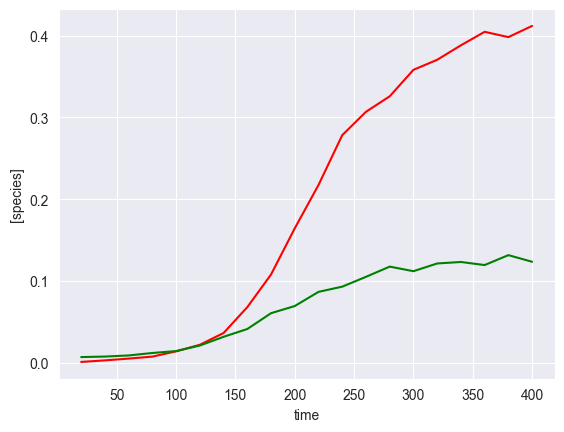

In [5]:
plot_gLV(yobs, times)

In [6]:
X, F = linearize_time_course_16S(yobs, times)
print(X.shape)
print(F)

(19, 3)
[[ 0.06410781  0.00451447]
 [ 0.030741    0.00864193]
 [ 0.02029504  0.01491441]
 [ 0.03195409  0.00920276]
 [ 0.02306859  0.01972501]
 [ 0.02551347  0.02072131]
 [ 0.031458    0.01324291]
 [ 0.02318223  0.01933004]
 [ 0.02108645  0.00678014]
 [ 0.01398885  0.01118549]
 [ 0.01235913  0.00355461]
 [ 0.00489876  0.00609444]
 [ 0.00298835  0.00563386]
 [ 0.00474679 -0.00245348]
 [ 0.00168398  0.00406172]
 [ 0.00233942  0.00074916]
 [ 0.00208133 -0.00155351]
 [-0.000806    0.0048483 ]
 [ 0.00168939 -0.00319625]]


In [7]:
# Define priors
mu_prior = 0.03

M_prior = 0.1

X shape: (19, 3)
F shape: (19, 2)
Number of species: 2
Manually determined mu prior
Manually determined M prior


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu_hat, M_ii_hat_p, M_ij_hat]


Output()

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 4 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


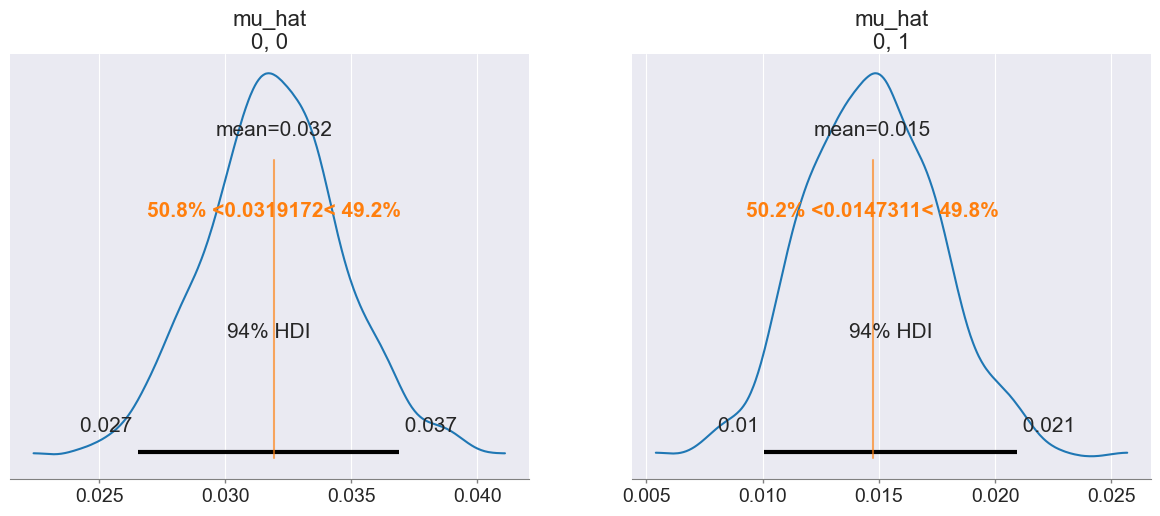

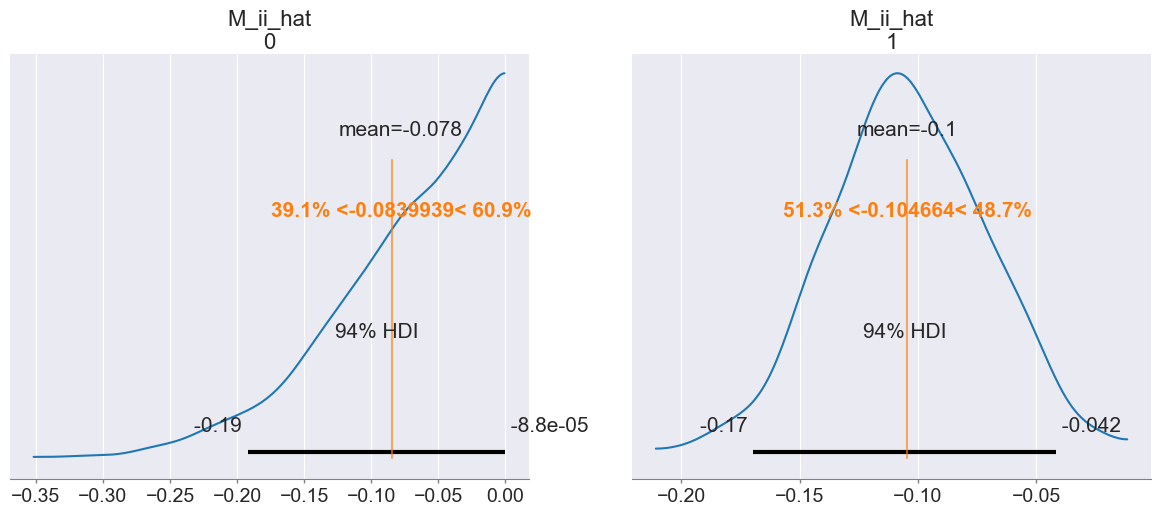

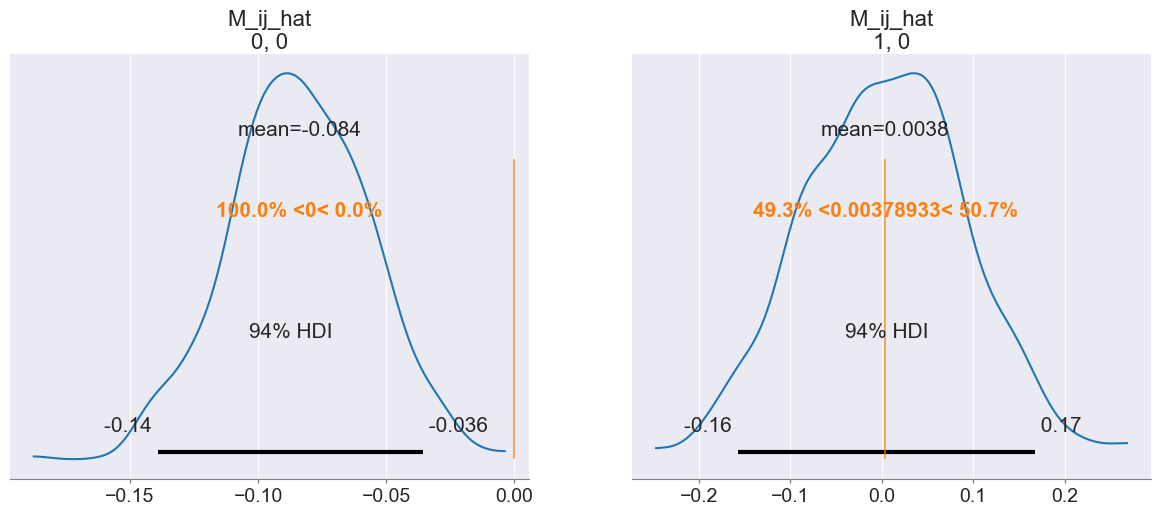

In [8]:
# Perform Bayesian inference without shrinkage

inference = infergLVbayes(X, F, mu_prior, M_prior)
idata = inference.run_bayes_gLV()

In [9]:
#inference.plot_posterior_a(idata, mu_hat_np, M_hat_np)

In [10]:
# Print summary

summary = az.summary(idata, var_names=["mu_hat", "M_ii_hat", "M_ij_hat", "M_hat", "sigma"])
print(summary[["mean", "sd", "r_hat"]])


# Save posterior samples to file
az.to_netcdf(idata, 'model_posterior.nc')

/Users/chaniaclare/anaconda3/bin/python3.12/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


                 mean     sd  r_hat
mu_hat[0, 0]    0.032  0.003    1.0
mu_hat[0, 1]    0.015  0.003    1.0
M_ii_hat[0]    -0.078  0.062    1.0
M_ii_hat[1]    -0.105  0.034    1.0
M_ij_hat[0, 0] -0.084  0.027    1.0
M_ij_hat[1, 0]  0.004  0.088    1.0
M_hat[0, 0]    -0.084  0.027    1.0
M_hat[0, 1]     0.000  0.000    NaN
M_hat[1, 0]     0.004  0.088    1.0
M_hat[1, 1]    -0.105  0.034    1.0
sigma[0]        0.007  0.001    1.0


'model_posterior.nc'

(2, 500, 2, 2)
(2, 500, 1, 2)
Using the following parameters for gLV simulation: {'num_species': 2, 'mu': array([0.03186235, 0.01472449]), 'M': array([[-0.08428906,  0.        ],
       [ 0.00541343, -0.10554024]]), 'epsilon': array([], shape=(2, 0), dtype=float64)}


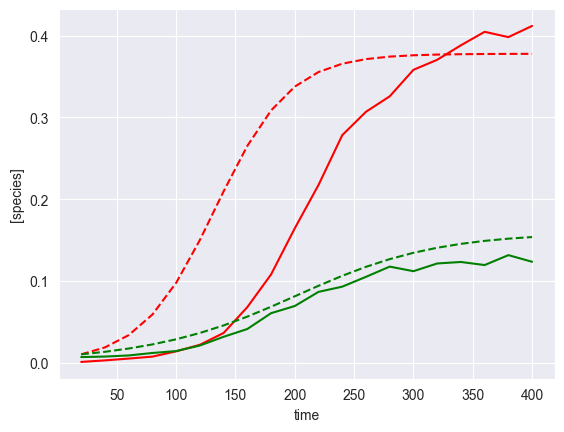

In [11]:
init_species_start = 0.01
sim_gLV_class = sim_gLV()
curve_compare(idata, F, mu_prior, M_prior, times, yobs, init_species_start, sim_gLV_class)

## Perform Bayesian inference with shrinkage

In [12]:
n_obs = times.shape[0] - 1
num_species = F.shape[1]
nX = num_species
noise_stddev = 0.1

# Params for shrinkage on M_ij (non diagonal elements)
DA = nX*nX - nX

DA0 = 1     # expected number of non zero entries in M_ij
N = n_obs - 2

DA: 2, DA0: 1, N: 17, noise_stddev: 0.1
Manually determined mu prior
Manually determined M prior


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu_hat, M_ii_hat_p, c2, tau, lam, M_ij_hat]


Output()

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Sampling 2 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━  94% 0:00:01 / 0:00:05

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 6 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


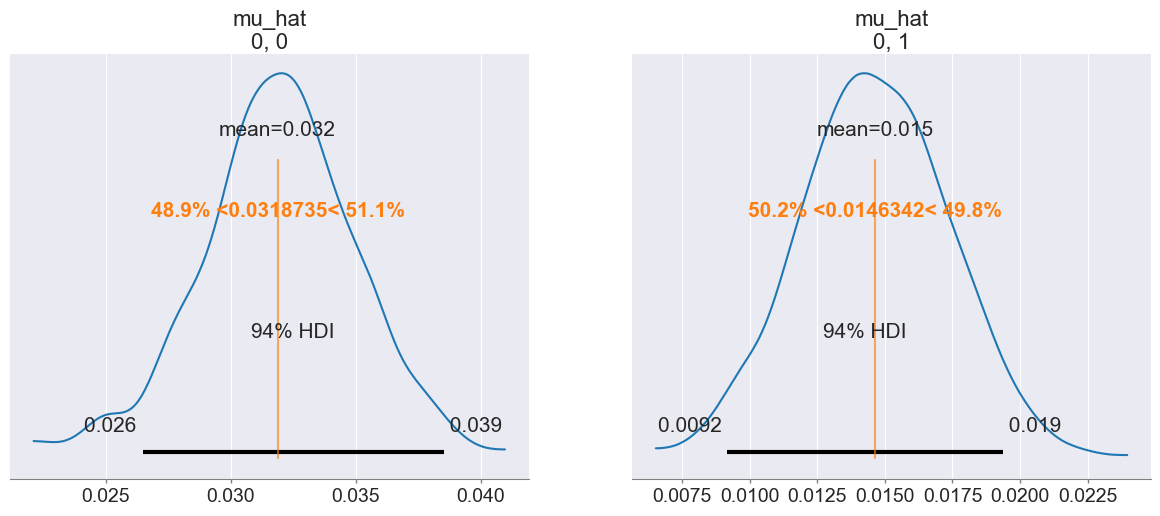

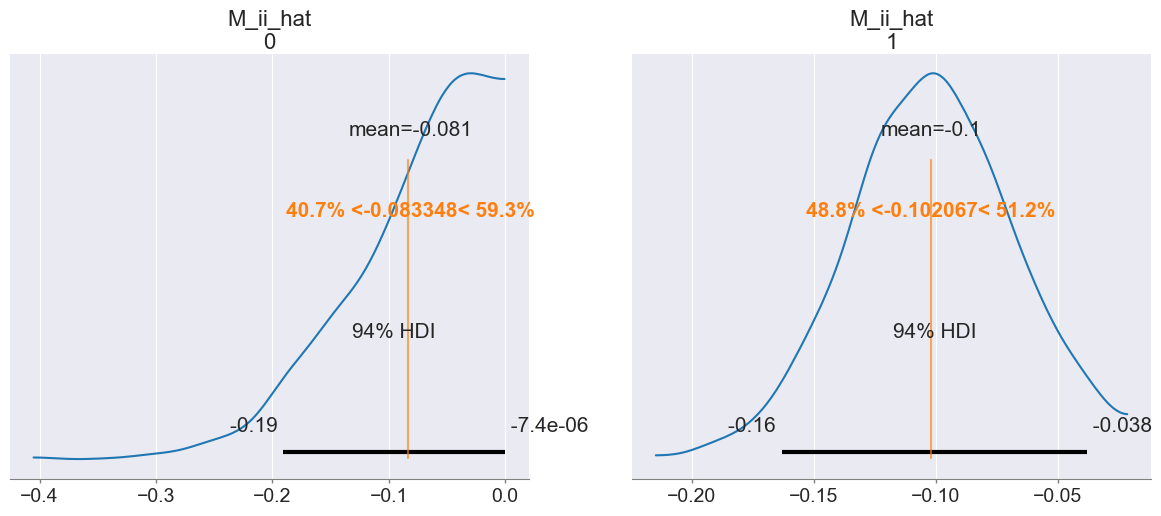

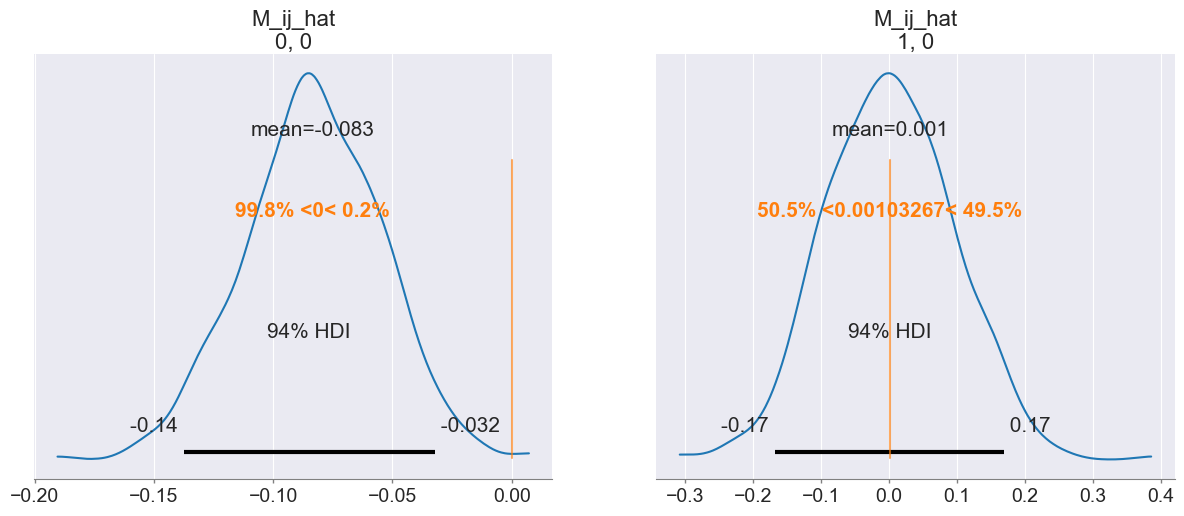

In [13]:
inference = infergLVbayes(X, F, mu_prior, M_prior, DA=DA, DA0=DA0, N=N, noise_stddev=noise_stddev)
idata = inference.run_bayes_gLV_shrinkage()

In [14]:
# Print summary

summary = az.summary(idata, var_names=["mu_hat", "M_ii_hat", "M_ij_hat", "M_hat", "sigma"])
print(summary[["mean", "sd", "r_hat"]])


# Save posterior samples to file
az.to_netcdf(idata, 'model_posterior.nc')

                 mean     sd  r_hat
mu_hat[0, 0]    0.032  0.003   1.01
mu_hat[0, 1]    0.015  0.003   1.01
M_ii_hat[0]    -0.081  0.062   1.00
M_ii_hat[1]    -0.102  0.033   1.00
M_ij_hat[0, 0] -0.083  0.028   1.00
M_ij_hat[1, 0]  0.001  0.093   1.00
M_hat[0, 0]    -0.083  0.028   1.00
M_hat[0, 1]     0.000  0.000    NaN
M_hat[1, 0]     0.001  0.093   1.00
M_hat[1, 1]    -0.102  0.033   1.00
sigma[0]        0.007  0.001   1.01


/Users/chaniaclare/anaconda3/bin/python3.12/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


'model_posterior.nc'

(2, 500, 2, 2)
(2, 500, 1, 2)
Using the following parameters for gLV simulation: {'num_species': 2, 'mu': array([0.03193045, 0.01460738]), 'M': array([[-0.08316311,  0.        ],
       [-0.00034683, -0.10153014]]), 'epsilon': array([], shape=(2, 0), dtype=float64)}


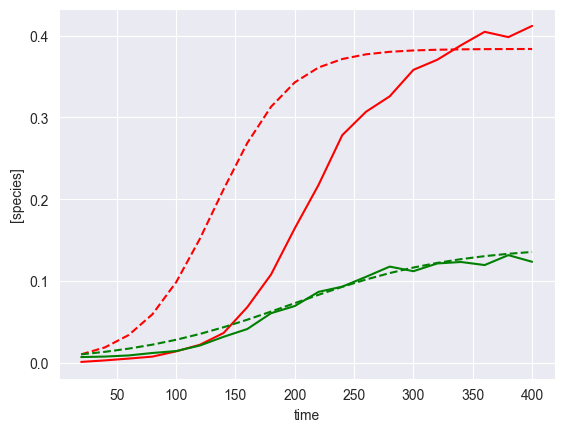

In [15]:
curve_compare(idata, F, mu_prior, M_prior, times, yobs, init_species_start, sim_gLV_class)